In [ ]:
!pip install torch torchvision matplotlib scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 866.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os

# List dataset directory
os.listdir('/content/drive/MyDrive/chest_xray')


['test', 'chest_xray', 'train', 'val', '__MACOSX']

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir   = '/content/drive/MyDrive/chest_xray/val'
test_dir  = '/content/drive/MyDrive/chest_xray/test'


Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data   = datasets.ImageFolder(val_dir, transform=transform)
test_data  = datasets.ImageFolder(train_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16)
test_loader  = DataLoader(test_data, batch_size=16)


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [ ]:
num_epochs = 5
train_loss_list, val_loss_list, val_acc_list = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(epoch_loss)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100 * correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%')


Epoch 1/5, Train Loss: 0.0712, Val Loss: 2.1270, Val Acc: 50.00%
Epoch 2/5, Train Loss: 0.0162, Val Loss: 2.5166, Val Acc: 56.25%
Epoch 3/5, Train Loss: 0.0117, Val Loss: 2.1264, Val Acc: 62.50%
Epoch 4/5, Train Loss: 0.0075, Val Loss: 2.3075, Val Acc: 62.50%
Epoch 5/5, Train Loss: 0.0132, Val Loss: 3.7119, Val Acc: 62.50%


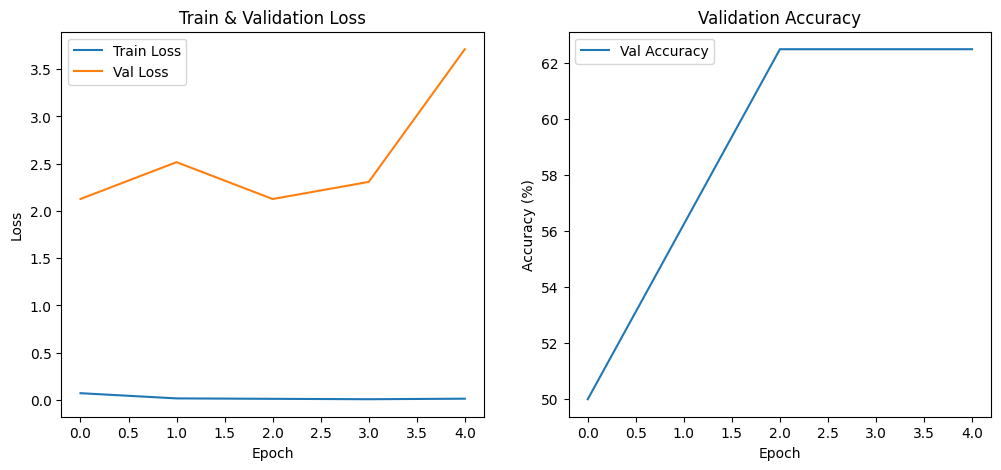

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


In [ ]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=train_data.classes))


              precision    recall  f1-score   support

      NORMAL       0.98      1.00      0.99       394
   PNEUMONIA       1.00      1.00      1.00      3881

    accuracy                           1.00      4275
   macro avg       0.99      1.00      1.00      4275
weighted avg       1.00      1.00      1.00      4275



In [ ]:
torch.save(model.state_dict(), '/content/pneumonia_classifier_resnet18.pth')


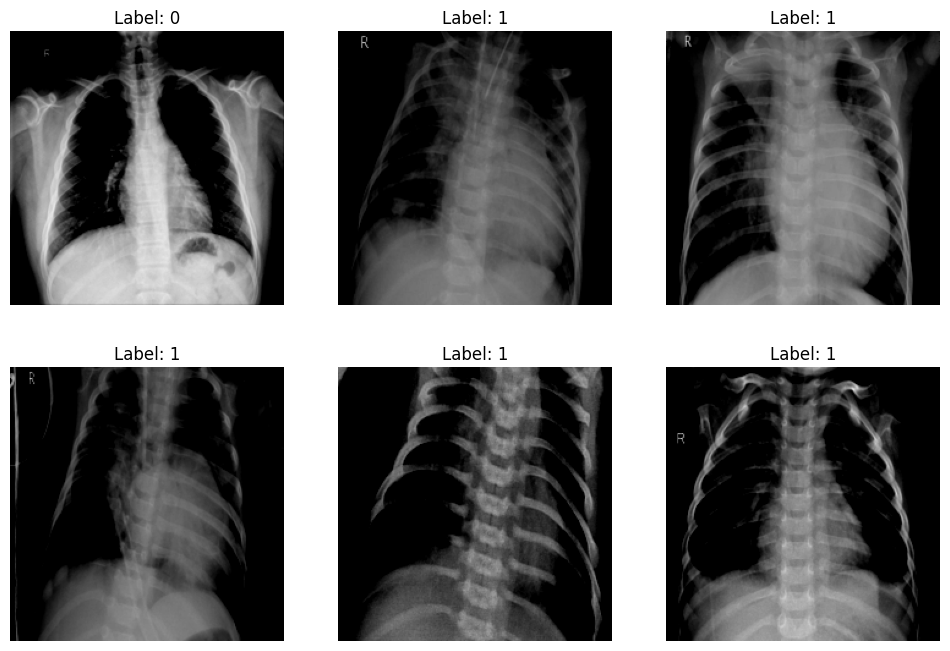

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display some random images from the dataset
def show_images(loader):
    dataiter = iter(loader)
    # Use next() instead of .next()
    images, labels = next(dataiter)

    # Get a batch of images and labels
    fig = plt.figure(figsize=(12, 8))
    for i in range(6):
        ax = fig.add_subplot(2, 3, i+1)
        # Ensure images are in the correct format for display (H, W, C) and convert to numpy array
        img_to_display = images[i].permute(1, 2, 0).numpy()
        # Handle the normalization applied earlier by denormalizing for display if necessary.
        # If normalization was done with mean 0.5 and std 0.5, uncomment the next two lines:
        # img_to_display = img_to_display * 0.5 + 0.5
        # img_to_display = np.clip(img_to_display, 0, 1) # clip values to be between 0 and 1

        ax.imshow(img_to_display)
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.show()

# Show images from the training set
show_images(train_loader)

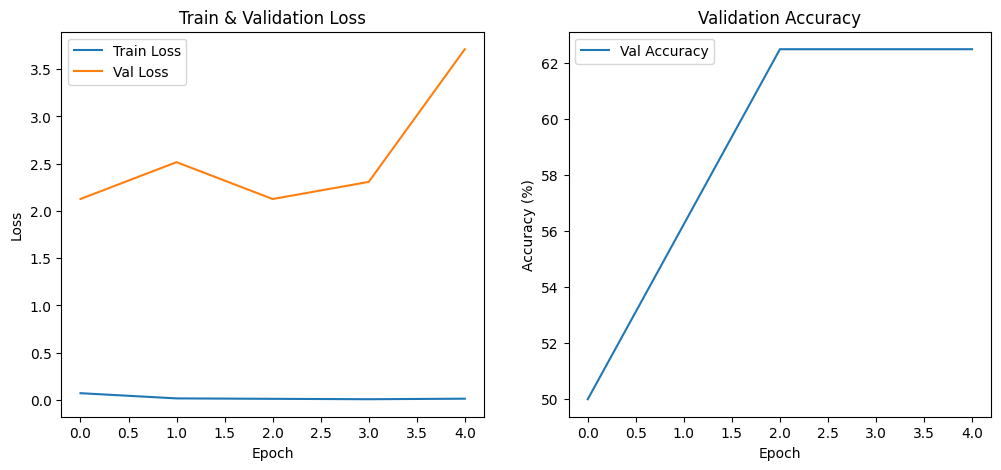

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.show()


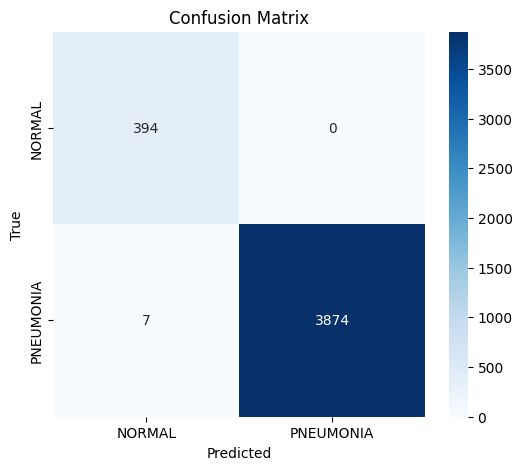

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install torch torchvision matplotlib scikit-learn opencv-python


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import cv2


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trained model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load('/content/pneumonia_classifier_resnet18.pth', map_location=device))  # replace with your path
model = model.to(device)
model.eval()

# Class labels
classes = ['Normal', 'Pneumonia']


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-28-d978ee7aa99b>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print('Uploaded file:', img_path)


Saving person1_virus_6.jpeg to person1_virus_6.jpeg
Uploaded file: person1_virus_6.jpeg


In [ ]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)


Prediction: Pneumonia


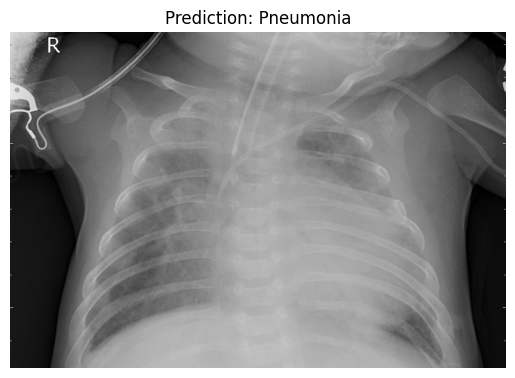

In [ ]:
# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    prediction = classes[predicted.item()]

# Show result
print(f"Prediction: {prediction}")

# Display uploaded image
plt.imshow(image, cmap='gray')
plt.title(f'Prediction: {prediction}')
plt.axis('off')
plt.show()


In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
    img_path = fn
    print('Uploaded file:', img_path)


Saving IM-0115-0001.jpeg to IM-0115-0001.jpeg
Uploaded file: IM-0115-0001.jpeg


In [ ]:
#image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)

Prediction: Normal


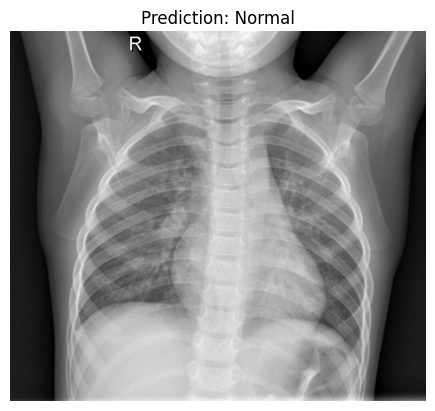

In [ ]:
# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    prediction = classes[predicted.item()]

# Show result
print(f"Prediction: {prediction}")

# Display uploaded image
plt.imshow(image, cmap='gray')
plt.title(f'Prediction: {prediction}')
plt.axis('off')
plt.show()
